In [1]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import random
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn_image as isns

sns.set_style("darkgrid")
isns.set_image(origin="upper")

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from utils import CustomImageDataset
from tqdm.notebook import tqdm

import os


from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
train_dataset = CustomImageDataset("./data/train_data.csv", normalize=True, batch_size=2000, device=device)
test_dataset = CustomImageDataset("./data/test_data.csv", normalize=True, batch_size=2000, device=device)

In [3]:
train_dataset[0][0].device

device(type='cuda', index=0)

## Dense Autoencoder

In [4]:
code_size = 64

encoder = EncoderDense(train_dataset[0][0].shape[1:], code_size, device=device)
decoder = DecoderDense(code_size, train_dataset[0][0].shape[1:], device=device)
autoencoder = AE(encoder, decoder)
autoencoder

AE(
  (encoder): EncoderDense(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=64, bias=True)
    (relu): ReLU()
  )
  (decoder): DecoderDense(
    (layer1): Linear(in_features=64, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [5]:
learning_rate = 1e-3
epochs = 500

# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
print(loss_fn)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

MSELoss()


In [6]:
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        pred = autoencoder(X)

        loss = loss_fn(pred, X)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            pred = autoencoder(X)

            test_loss += loss_fn(pred, X).item()

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")


Epoch   1/500: Train loss: 0.211055, Test loss: 0.189719
Epoch   2/500: Train loss: 0.163276, Test loss: 0.129198
Epoch   3/500: Train loss: 0.116778, Test loss: 0.100543
Epoch   4/500: Train loss: 0.096464, Test loss: 0.089499
Epoch   5/500: Train loss: 0.089946, Test loss: 0.087076
Epoch   6/500: Train loss: 0.087745, Test loss: 0.085691
Epoch   7/500: Train loss: 0.086701, Test loss: 0.085205
Epoch   8/500: Train loss: 0.086290, Test loss: 0.084867
Epoch   9/500: Train loss: 0.085984, Test loss: 0.084601
Epoch  10/500: Train loss: 0.085772, Test loss: 0.084441
Epoch  11/500: Train loss: 0.085662, Test loss: 0.084340
Epoch  12/500: Train loss: 0.085574, Test loss: 0.084283
Epoch  13/500: Train loss: 0.085509, Test loss: 0.084243
Epoch  14/500: Train loss: 0.085462, Test loss: 0.084201
Epoch  15/500: Train loss: 0.085421, Test loss: 0.084159
Epoch  16/500: Train loss: 0.085382, Test loss: 0.084118
Epoch  17/500: Train loss: 0.085345, Test loss: 0.084079
Epoch  18/500: Train loss: 0.08

torch.Size([28, 28])


<Axes: >

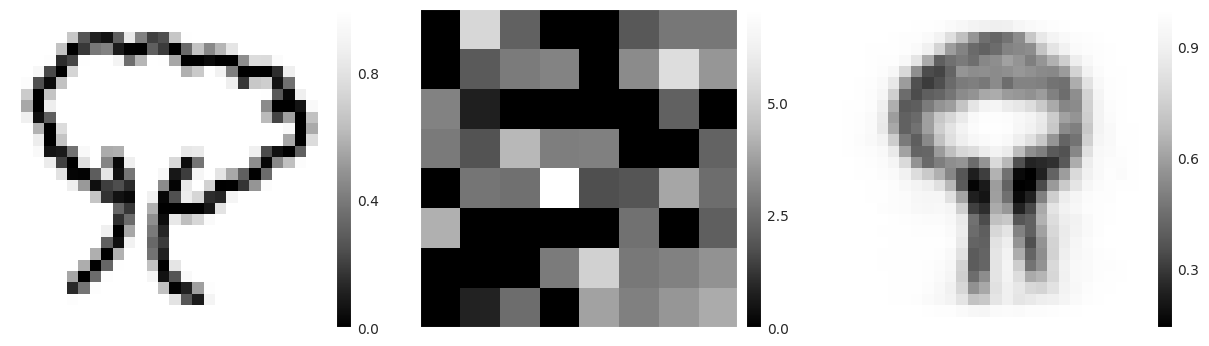

In [7]:
example_img = random.choice(train_dataset)
encoded_tensor = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((8,8))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0])
isns.imgplot(code, cmap="Greys_r", ax=ax[1])
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2])


## VAE

In [13]:
code_size = 256

encoder = EncoderDenseVAE(train_dataset[0][0].shape[1:], code_size, device=device)
decoder = DecoderDenseVAE(code_size, train_dataset[0][0].shape[1:], device=device)
# autoencoder = DenseVAE(encoder, decoder, beta=2e-7)
autoencoder = VAE(encoder, decoder, beta=1e-6)
autoencoder

VAE(
  (encoder): EncoderDenseVAE(
    (layer1): Linear(in_features=784, out_features=400, bias=True)
    (layer2): Linear(in_features=400, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=100, bias=True)
    (layer4): Linear(in_features=100, out_features=256, bias=True)
    (layer5): Linear(in_features=100, out_features=256, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (decoder): DecoderDenseVAE(
    (layer1): Linear(in_features=256, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=200, bias=True)
    (layer3): Linear(in_features=200, out_features=400, bias=True)
    (layer4): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [14]:
learning_rate = 1e-4
epochs = 500

# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
# loss_fn = nn.MSELoss()
print(loss_fn)

# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=learning_rate)

MSELoss()


In [15]:
train_loss_history = []
test_loss_history = []
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        z, _, _ = autoencoder(X)

        loss = loss_fn(X, z) + autoencoder.beta*autoencoder.encoder.kl_loss

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            z, _, _ = autoencoder(X)
            loss = loss_fn(X, z) + autoencoder.beta*autoencoder.encoder.kl_loss
            test_loss += loss.item()
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")

Epoch   1/500: Train loss: 2.899094, Test loss: 2.416050
Epoch   2/500: Train loss: 2.054241, Test loss: 1.549617
Epoch   3/500: Train loss: 1.263683, Test loss: 0.937230
Epoch   4/500: Train loss: 0.803262, Test loss: 0.659030
Epoch   5/500: Train loss: 0.599127, Test loss: 0.531732
Epoch   6/500: Train loss: 0.503848, Test loss: 0.468894
Epoch   7/500: Train loss: 0.453279, Test loss: 0.432768
Epoch   8/500: Train loss: 0.423683, Test loss: 0.410376
Epoch   9/500: Train loss: 0.404836, Test loss: 0.396158
Epoch  10/500: Train loss: 0.392335, Test loss: 0.386259
Epoch  11/500: Train loss: 0.383446, Test loss: 0.378915
Epoch  12/500: Train loss: 0.377447, Test loss: 0.373812
Epoch  13/500: Train loss: 0.372492, Test loss: 0.370726
Epoch  14/500: Train loss: 0.369228, Test loss: 0.364265
Epoch  15/500: Train loss: 0.366043, Test loss: 0.363576
Epoch  16/500: Train loss: 0.364148, Test loss: 0.362512
Epoch  17/500: Train loss: 0.362253, Test loss: 0.363012
Epoch  18/500: Train loss: 0.36

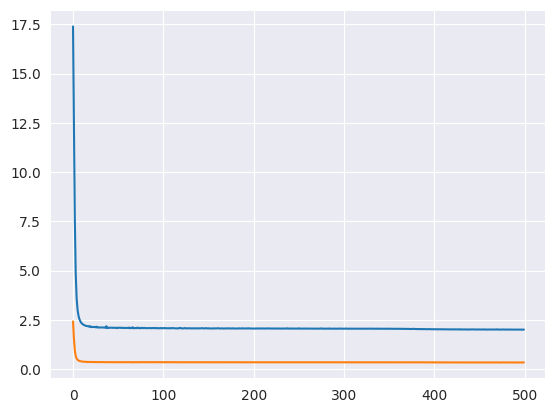

In [16]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.show()

torch.Size([28, 28])


<Axes: >

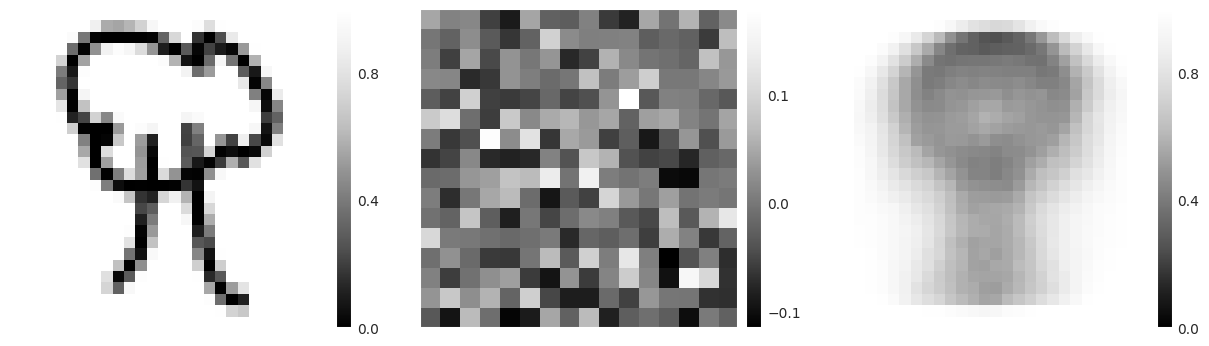

In [34]:
example_img = random.choice(train_dataset)
encoded_tensor, z_loc, z_log_scale = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((16,16))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0], vmin=0, vmax=1)
isns.imgplot(code, cmap="Greys_r", ax=ax[1], vmin=code.min())
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2], vmin=0, vmax=1)